In [1]:
#Imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from forecasting_model import ForecastingModel
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error)

In [2]:
# Create a dataset
seq_len = 92
train_size = 460
data = list(pd.read_csv("bonn_ndvi.csv")["ndvi"])[0:]
x = np.array(data[:train_size])
forecast = np.array(data[train_size:])
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))

In [3]:
# Training Loop
device = "mps"
EPOCHS = 40
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
model = ForecastingModel(seq_len, embed_size=64, nhead=16, 
                         dim_feedforward=1024, dropout=0.1, 
                         conv1d_emb=False, conv1d_kernel_size=5, device=device).to(device)
model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")

Epoch 1/40: Loss=0.001333993044681847
Epoch 2/40: Loss=0.0002953777729999274
Epoch 3/40: Loss=0.003301712218672037
Epoch 4/40: Loss=2.1325813577277586e-05
Epoch 5/40: Loss=0.000504442723467946
Epoch 6/40: Loss=0.00027992468676529825
Epoch 7/40: Loss=0.0002098612458212301
Epoch 8/40: Loss=0.0003187440743204206
Epoch 9/40: Loss=0.0020708530209958553
Epoch 10/40: Loss=3.451979500823654e-05
Epoch 11/40: Loss=0.0003921801981050521
Epoch 12/40: Loss=0.00042792496969923377
Epoch 13/40: Loss=0.00025111285503953695
Epoch 14/40: Loss=0.0011058642994612455
Epoch 15/40: Loss=0.0007744611939415336
Epoch 16/40: Loss=1.0033617400040384e-05
Epoch 17/40: Loss=0.0013286813627928495
Epoch 18/40: Loss=0.0011884140549227595
Epoch 19/40: Loss=0.0007152747130021453
Epoch 20/40: Loss=4.641806299332529e-05
Epoch 21/40: Loss=0.0004847597738262266
Epoch 22/40: Loss=0.0003269514418207109
Epoch 23/40: Loss=8.225881902035326e-05
Epoch 24/40: Loss=0.006614283192902803
Epoch 25/40: Loss=0.0007782660541124642
Epoch 26

In [4]:
# Prediction Loop
model.eval()
for ff in range(len(forecast)):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape((1, seq_len, 1)).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))

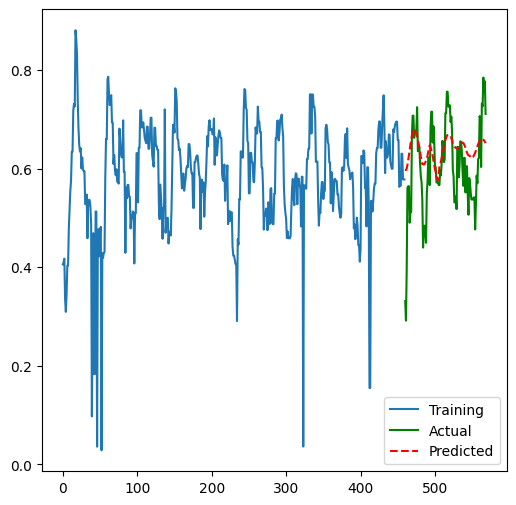

In [5]:
# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(train_size), data[:train_size], label="Training")
plt.plot(range(train_size, len(data)), forecast, 'g-', label="Actual")
plt.plot(range(train_size, len(data)), x[train_size:], 'r--', label="Predicted")
plt.legend()
fig.savefig("./ndvi_example.png")

In [6]:
# Export Metrics
print(f"MSE: {mean_squared_error(x[train_size:], forecast)}")
print(f"MAE: {mean_absolute_error(x[train_size:], forecast)}")

MSE: 0.006782310717931627
MAE: 0.06265928412796162
